# Linear Buckling Analysis with ML GP PDE solver
V2 adding moment constraints directly into multivariate GP

In [1]:
# main ML inputs
# --------------
(num_interior, num_bndry, num_test) = (500, 400, 50)
# (num_interior, num_bndry, num_test) = (700, 500, 50)
# (num_interior, num_bndry, num_test) = (1000, 400, 50)
num_domain = num_interior
Lx, Ly = (0.4, 0.4)

num_epochs = 1000 #3000 # 5000
learning_rate = 1e-5 # 1e-5 # can be much higher here?
alpha = 1e-5 # regularization constant

In [2]:
# panel linear static inputs
# buckling inputs
# ----------------

# aluminum plate material properties
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)
(a, b) = (3, 1)

axial = True
if axial:
    Nxx, Nxy, Nyy = (1e3, 0, 0)
else:
    Nxx, Nxy, Nyy = (0, 1e2, 0)

# predict the buckling load factor (BLF)
pi = 3.14159
if axial:
    pred_buckling_load = pi**2 * D / b**2 * 4.0 
    pred_load_factor = pred_buckling_load / Nxx
    sigma = 0.5 * pred_load_factor
    print(f"{pred_load_factor=}")

# corrected prediction from FEA
# lam[i]=(16.1634202010277+0j)
pred_load_factor = 16.163432


pred_load_factor=31.633294000320518


2024-12-05 09:51:31.764281: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 09:51:31.765762: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 09:51:31.771038: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 09:51:31.781146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733410291.795777   65690 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733410291.79

type(x_train)=<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


2024-12-05 09:51:33.237382: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


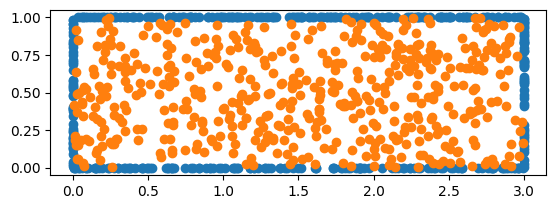

In [3]:
# compute the linear static analysis inputs and mesh domain of collocation pts
# ----------------------------------------------------------------------------
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

num_interior = num_domain
DTYPE = tf.float32

# set the boundary of the panel
xmin = 0; xmax = a
ymin = 0; ymax = b

lb = tf.constant([xmin, ymin], dtype=DTYPE)
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# generate the collocation points on the interior
def gen_collocation_points(num_domain, minval, maxval):
    x_r = tf.random.uniform((num_domain,1), minval[0], maxval[0], dtype=DTYPE)
    y_r = tf.random.uniform((num_domain,1), minval[1], maxval[1], dtype=DTYPE)
    X_r = tf.concat([x_r, y_r], axis=1)
    # data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
    # return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)
    return tf.Variable(X_r, dtype=DTYPE)

x_train = gen_collocation_points(num_domain, lb, ub)
x_test = gen_collocation_points(num_test, lb, ub)
print(f"{type(x_train)=}")

x = x_train[:,0:1]
y = x_train[:,1:2]

x2 = x_test[:,0:1]
y2 = x_test[:,1:2]

# generate boundary domain points
assert num_bndry % 2 == 0
xb_frac = b / (a + b)
N_xb = int(xb_frac * num_bndry)
N_yb = num_bndry- N_xb
x_b1 = tf.random.uniform((N_yb,1), lb[0], ub[0], dtype=DTYPE)
y_b1 = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_yb,1), 0.5, dtype=DTYPE)
X_b1 = tf.concat([x_b1, y_b1], axis=1)

# boundary data on x edges
y_b2 = tf.random.uniform((N_xb,1), lb[1], ub[1], dtype=DTYPE)
x_b2 = lb[0] + (ub[0] - lb[0]) * \
    tf.keras.backend.random_bernoulli((N_xb,1), 0.5, dtype=DTYPE)
# print(f"{x_b2=}")
X_b2 = tf.concat([x_b2, y_b2], axis=1)
# print(f"{X_b2=}")
# print(f"{x_b2=}")

x_bndry = tf.Variable(tf.concat([X_b1, X_b2], axis=0), dtype=DTYPE)

# plot the data to check
plt.scatter(x_bndry[:,0], x_bndry[:,1])
plt.scatter(x_train[:,0], x_train[:,1]) # only show 1000 of the points
plt.gca().set_aspect('equal')
plt.show()

In [4]:
# define vectorized versions of the kernel functions
# like 1000x faster at assembling covariance functions

L_tf = tf.constant(np.array([Lx, Ly]), dtype=DTYPE)
def kernel2d_tf(x, xp):
    # x input is N x 1 x 2 array, xp is 1 x M x 2 array
    # xbar is then an N x M x 2 shape array
    # print(f"{x=} {L_tf=}")
    xbar = (x - xp) / L_tf
    # output is N x M matrix of kernel matrix
    return tf.exp(-0.5 * tf.reduce_sum(tf.pow(xbar, 2.0), axis=-1))

def d_fact(xbar, L):
    return L**(-1.0) * (-xbar)

def d2_fact(xbar, L):
    return L**(-2.0) * (-1.0 + xbar**2)

def d4_fact(xbar,L):
    return L**(-4.0) * (3.0 - 6.0 * xbar**2 + xbar**4)

def d6_fact(xbar,L):
    return L**(-6.0) * (-15 + 45 * xbar**2 - 15 * xbar**4 + xbar**6)

def d8_fact(xbar,L):
    return L**(-8.0) * (105 - 420 * xbar**2 + 210 * xbar**4 - 28 * xbar**6 + xbar**8)

def dx2_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    # TODO : shear or general case later (just axial now)
    return K * (d2_fact(x1bar, Lx))

def dy2_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)
    return K * (d2_fact(x2bar, Ly))

def doubledx2_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    # TODO : shear or general case later (just axial now)
    return K * (d4_fact(x1bar, Lx))

def doubledy2_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)
    return K * (d4_fact(x2bar, Ly))

def kernel2d_bilapl_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    return K * (d4_fact(x1bar,Lx) + 2.0 * d2_fact(x1bar, Lx) * d2_fact(x2bar, Ly) + d4_fact(x2bar, Ly))

def kernel2d_double_bilapl_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    return K * (d8_fact(x1bar,Lx) + \
                4.0 * d6_fact(x1bar, Lx) * d2_fact(x2bar, Ly) +\
                6.0 * d4_fact(x1bar, Lx) * d4_fact(x2bar, Ly) +\
                4.0 * d2_fact(x1bar, Lx) * d6_fact(x2bar, Ly) +\
                d8_fact(x2bar, Ly))

def dx2_bilapl_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    # TODO : shear or general case later (just axial now)
    return K * \
        (d6_fact(x1bar,Lx) + 2.0 * d4_fact(x1bar, Lx) * d2_fact(x2bar, Ly) + d2_fact(x1bar, Lx) * d4_fact(x2bar, Ly))

def dy2_bilapl_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)
    return K * \
        (d4_fact(x1bar,Lx) * d2_fact(x2bar, Ly) + 2.0 * d2_fact(x1bar, Lx) * d4_fact(x2bar, Ly) + d6_fact(x2bar, Ly))

def dx2_dy2_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)
    return K * d2_fact(x1bar, Lx) * d2_fact(x2bar, Ly)

num_interior=500 num_all=900
done with full matrix assembly..
min_eigval=-0.7584115 max_eigval=19998582.0
done with eigenvalues solve


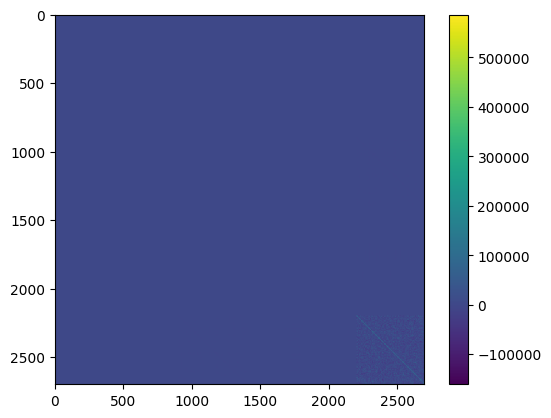

In [5]:
# compute the block matrix Sigma = [cov(w_int, w_int), cov(w_int, w_bndry), cov(w_int, nabla^4 w_int),
#                                   cov(w_bndry, w_int), cov(w_bndry, w_bndry), cov(w_bndry, nabla^4 w_bndry),
#                                   cov(nabla^4 w_int, w_int), cov(nabla^4 w_int, w_bndry), cov(nabla^4 w_int, nabla^4 w_int) ]
# not a function of theta..
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

n_block = 3 * num_interior + 3 * num_bndry
x_all = tf.concat([x_train, x_bndry], axis=0)
num_all = num_interior + num_bndry

# components of the multivariate GP
# 1 - w at interior and bndry points
# 2 - d^2w/dx^2 at interior and bndry points
# 3 - d^2w/dy^2 at bndry points
# 4 - nabla^4 w at interior points

# 11 - interior+bndry self-covariance
x_all_L = tf.expand_dims(x_all, axis=1)
x_all_R = tf.expand_dims(x_all, axis=0)
K11 = tf.constant(kernel2d_tf(x_all_L, x_all_R), dtype=DTYPE)

x_interior_L = tf.expand_dims(x_train, axis=1)
x_interior_R = tf.expand_dims(x_train, axis=0)
x_bndry_L = tf.expand_dims(x_bndry, axis=1)
x_bndry_R = tf.expand_dims(x_bndry, axis=0)

# 12 - w with dx2
K12 = tf.constant(dx2_kernel_tf(x_all_L, x_all_R))
# 13 - w with dy2
K13 = tf.constant(dy2_kernel_tf(x_all_L, x_bndry_R))
# 14 - w with nabla^4 w
K14 = tf.constant(kernel2d_bilapl_tf(x_all_L, x_interior_R))
# 22 - dx2 with dx2
K22 = tf.constant(doubledx2_kernel_tf(x_all_L, x_all_R))
# 23 - dx2 with dy2
K23 = tf.constant(dx2_dy2_kernel_tf(x_all_L, x_bndry_R))
# 24 - dx2 with nabla^4 w
K24 = tf.constant(dx2_bilapl_kernel_tf(x_all_L, x_interior_R))
# 33 - dy2 with dy2
K33 = tf.constant(doubledy2_kernel_tf(x_bndry_L, x_bndry_R))
# 34 - dy2 with nabla^4 w
K34 = tf.constant(dy2_bilapl_kernel_tf(x_bndry_L, x_interior_R))
# 44 - nabla^4 w with itself
K44 = tf.constant(kernel2d_double_bilapl_tf(x_interior_L, x_interior_R))

print(f"{num_interior=} {num_all=}")
# print(f"{K11.shape=} {K12.shape=} {K22.shape=}")
# print(f"{K13.shape=} {K23.shape=} {K33.shape=}")

# assemble full covariance matrix
_row1 = tf.constant(tf.concat([K11, K12, K13, K14], axis=1))
_row2 = tf.constant(tf.concat([tf.transpose(K12), K22, K23, K24], axis=1))
_row3 = tf.constant(tf.concat([tf.transpose(K13), tf.transpose(K23), K33, K34], axis=1))
_row4 = tf.constant(tf.concat([tf.transpose(K14), tf.transpose(K24), tf.transpose(K34), K44], axis=1))
Kblock_prereg = tf.concat([_row1, _row2, _row3, _row4], axis=0)

print(f"done with full matrix assembly..")

# apply robust regularization w.r.t. the max eigenvalue, namely we add epsilon * I term to matrix
# where epsilon = alpha * lambda_max
# alpha = 1e-5
# alpha = 1e-3
eigvals = np.linalg.eigvalsh(Kblock_prereg)
min_eigval = np.min(eigvals)
max_eigval = np.max(eigvals)
print(f"{min_eigval=} {max_eigval=}")
eps = alpha * max_eigval

print("done with eigenvalues solve")

Kblock = tf.constant(Kblock_prereg + eps * tf.eye(n_block), dtype=DTYPE)

# double check eigvals again
# print("double check eivals again--")
# eigvals = np.linalg.eigvalsh(Kblock)
# min_eigval = np.min(eigvals)
# max_eigval = np.max(eigvals)
# print(f"{min_eigval=} {max_eigval=}")

# show the matrix image to see if positive definite roughly
plt.imshow(Kblock)
plt.colorbar()

In [6]:
# define GP vectors and factor cov matrix into LU
# -----------------------------------------------

# setup lambda as trainable parameter too
# lam = tf.Variable(pred_load_factor, trainable=True, dtype=DTYPE)

K_lu = tf.linalg.lu(Kblock)

w_ext = tf.zeros(shape=(num_bndry,1), dtype=DTYPE)
# now theta includes the w int points and Gw interior points and also lam
# theta_arr = tf.zeros(shape=(num_domain * 2 + 1,1), dtype=DTYPE)
# theta_arr = np.random.rand(2 * num_domain + 1, 1)
# theta_arr = tf.ones(shape=(num_domain * 2 + 1, 1), dtype=DTYPE)

dx2_ext = w_ext * 0.0
dy2_ext = w_ext * 0.0

# theta sets [w_int, dx2_w_int, lam]
theta_arr = np.zeros(shape=(2 * num_domain + 1,1))
theta_arr[-1,0] = pred_load_factor # set lam init

# pick one of points nearest the middle a/2, b/2
left_dist = (x_train[:,0] - a/6.0)**2 + (x_train[:,1] - b/2.0)**2
ind = tf.argmin(left_dist)
theta_arr[ind,0] = -1e-3

left_dist = (x_train[:,0] - 5.0 * a/6.0)**2 + (x_train[:,1] - b/2.0)**2
ind = tf.argmin(left_dist)
theta_arr[ind,0] = -1e-3

cent_dist = (x_train[:,0] - a/2.0)**2 + (x_train[:,1] - b/2.0)**2
ind = tf.argmin(cent_dist)
theta_arr[ind,0] = 1e-3 # set init value of w somewhere so not 0 norm

# [5,0] = 1.0 # best to choose some middle point as the only nonzero part?
theta = tf.Variable(theta_arr, trainable=True, dtype=DTYPE)

# print(f"{w_ext.shape=}")
# nabla4_w = 
# nabla4_w2 = tf.reshape(nabla4_w, shape=(num_domain,1))
# print(f"{nabla4_w2.shape=}")

# _temp = tf.concat([w_ext, nabla4_w2], axis=0)
# fixed_vec = tf.constant(_temp, dtype=DTYPE)

In [ ]:
# define our optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [27]:
for epoch in range(num_epochs):
    # record the loss gradient
    with tf.GradientTape(persistent=True) as tape:
        # construct full GP f vector
        w_int = theta[:num_interior]
        dx2_int = theta[num_interior:-1]
        lam = theta[-1]
        # lam = pred_load_factor # try constant for a minute
        # lam = 8.0
        nabla4_w = -lam / D * Nxx * dx2_int
        w_full = tf.concat([w_int, w_ext, dx2_int, dx2_ext, dy2_ext, nabla4_w], axis=0)

        # normalize w_full by w_norm to prevent trivial soln in buckling analysis
        w_norm = tf.linalg.norm(w_int)
        w_full_hat = w_full / w_norm

        # print(f"{w_full=}")
        ans = tf.linalg.lu_solve(*K_lu, rhs=w_full_hat)
        # print(f"{ans=}")

        loss = tf.tensordot(tf.transpose(w_full_hat), ans, axes=1)
        loss *= 1e3

        # add norm regularization term to prevent trivial soln (since buckling trivial w = 0 soln is technically a soln, but not one we care about)
        # this didn't work very well => just focuses on this term not PDE solving
        # loss += (w_norm - 1)**2 # * 1e4
        # # loss *= 1e3 # *= D

    loss_gradient = tape.gradient(loss, theta)
    # print(f"{loss_gradient=}")

    # could change to Gauss-newton algorithm here instead.. would prob be better

    # gradient descent with adam optimizer
    optimizer.apply_gradients(
        [(loss_gradient, theta)]
    )
    del tape

    loss_val = loss.numpy()[0,0]
    eigval = lam.numpy()[0]
    print(f"{epoch=}\t{loss_val=}\t{eigval=}")

# print(f"{theta=}")

epoch=0	loss_val=3.6896358	eigval=16.188337
epoch=1	loss_val=3.6896713	eigval=16.188347
epoch=2	loss_val=3.6896923	eigval=16.188356
epoch=3	loss_val=3.689707	eigval=16.188366
epoch=4	loss_val=3.689721	eigval=16.188375
epoch=5	loss_val=3.6897244	eigval=16.188385
epoch=6	loss_val=3.6897237	eigval=16.188395
epoch=7	loss_val=3.68973	eigval=16.188404
epoch=8	loss_val=3.6897342	eigval=16.188414
epoch=9	loss_val=3.6897395	eigval=16.188423
epoch=10	loss_val=3.6897333	eigval=16.188433
epoch=11	loss_val=3.6897085	eigval=16.188442
epoch=12	loss_val=3.6896632	eigval=16.188452
epoch=13	loss_val=3.6896143	eigval=16.188461
epoch=14	loss_val=3.6895554	eigval=16.18847
epoch=15	loss_val=3.689513	eigval=16.18848
epoch=16	loss_val=3.6894767	eigval=16.18849
epoch=17	loss_val=3.6894631	eigval=16.1885
epoch=18	loss_val=3.6894634	eigval=16.188509
epoch=19	loss_val=3.689463	eigval=16.188519
epoch=20	loss_val=3.6894584	eigval=16.188528
epoch=21	loss_val=3.689439	eigval=16.188538
epoch=22	loss_val=3.6894252	eigv

In [28]:
# predict the values at a grid of points (a mesh) so we can view predicted contour of the solution
# using the mean interpolated from trained values
import numpy as np

n = 100
ngrid = n * n
_xgrid = np.linspace(0.0, a, n)
_ygrid = np.linspace(0.0, b, n)
X, Y = np.meshgrid(_xgrid, _ygrid)
xgrid = np.reshape(X, newshape=(ngrid,1))
ygrid = np.reshape(Y, newshape=(ngrid,1))
x_grid = np.concatenate([xgrid, ygrid], axis=1)

# old non-vectorized way
# K_train = np.array([[kernel2d(x_all[i,:], x_all[j,:]) for j in range(num_all)] for i in range(num_all)])
# K_cross = np.array([[kernel2d(x_grid[i,:], x_all[j,:]) for j in range(num_all)] for i in range(ngrid)])

# vectorized way like 100x faster
K_train = kernel2d_tf(x_all_L, x_all_R)
x_grid_L = tf.expand_dims(tf.constant(x_grid, dtype=DTYPE), axis=1)
K_cross = kernel2d_tf(x_grid_L, x_all_R)

max_eigval = np.max(np.linalg.eigvalsh(K_train))
W_grid = K_cross @ np.linalg.solve(K_train + 1e-5 * max_eigval * np.eye(num_all), w_full[:num_all,:])
W = np.reshape(W_grid, newshape=(n, n))

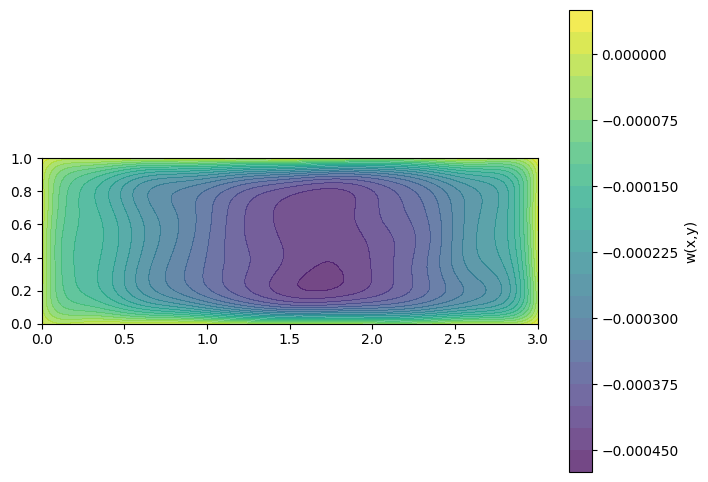

In [29]:
import matplotlib.pyplot as plt
# now plot the predicted solution contour
plt.figure(figsize=(8, 6))
colors = plt.contourf(X, Y, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
plt.gca().set_aspect('equal')
plt.colorbar(colors, label="w(x,y)")  # Colorbar for reference

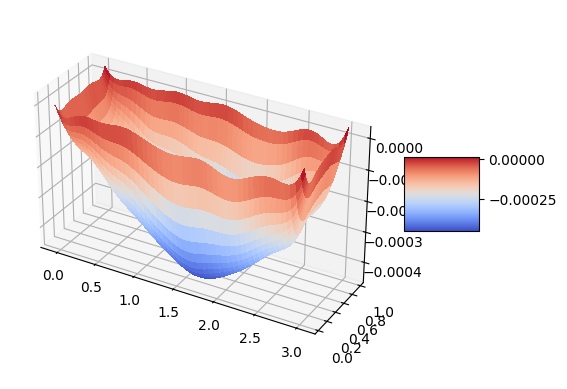

In [30]:
import matplotlib.pyplot as plt
from matplotlib import cm
# now plot the predicted solution surface in 3d
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=1)
ax.set_aspect('equalxy')
plt.show()